<a href="https://colab.research.google.com/github/deha388/unet/blob/master/Sec_of_Unet_Arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import glob
from scipy import misc
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [7]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

M_PATH = 'drive/My Drive/drone_train1/'
TRAIN_PATH = 'drive/My Drive/drone_train2/'
TEST_PATH = 'drive/My Drive/drone_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
#The images in the dataset are very large. The dimensions have been updated.
#Dataset has been set up for this operation. According to their ID numbers, their images were foldered together with their masks.
# Originaldatensatz auf Kaggle:
# https://www.kaggle.com/bulentsiyah/semantic-drone-dataset

In [8]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH +id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)            
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
        #maskData The image pixels are updated to 0 and 255 by taking the zeros value to its maximum value. 
            
    Y_train[n] = mask


  0%|          | 0/211 [00:00<?, ?it/s]

Resizing training images and masks



100%|██████████| 211/211 [14:51<00:00,  4.23s/it]


In [9]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')


  0%|          | 0/15 [00:00<?, ?it/s]

Resizing test images



100%|██████████| 15/15 [01:57<00:00,  7.85s/it]

Done!


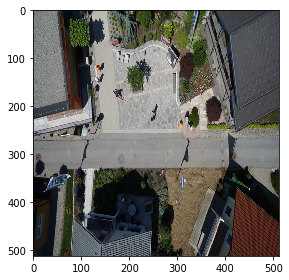

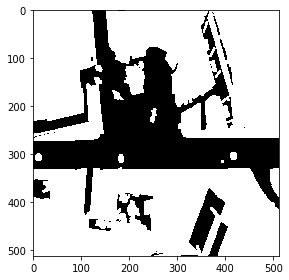

In [11]:
for i in range(1):
   image_x = random.randint(0, len(train_ids))
   imshow(X_train[image_x])
   plt.show()
   imshow(np.squeeze(Y_train[image_x]))
   plt.show()

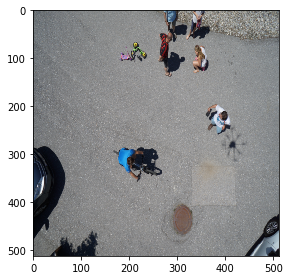

In [13]:
for i in range(1):
  ix = random.randint(0, len(test_ids))
  imshow(X_test[ix])
  plt.show()


In [27]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def dice_coef_loss(y_true, y_pred):
   return -dice_coef(y_true, y_pred)


#another accuracy metrics and loss calculation

In [14]:
#unet model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#encode
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

#middle
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

#decode 

u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2], axis=3)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss=dice_coef_loss, metrics=[dice_coef])

model.summary()
#output imagesize same with input



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [15]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
#Loss not improve so with earlystopping gain time
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.01, batch_size=16, epochs=50,
                    callbacks=[earlystopper, checkpointer])


#validation data taking with validation split

print('Done!')


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5868
Epoch 00001: val_loss improved from inf to 0.68156, saving model to model.h5
13/13 [==============================] - 17s 1s/step - loss: 0.6929 - accuracy: 0.5868 - val_loss: 0.6816 - val_accuracy: 0.5295
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.6410
Epoch 00002: val_loss improved from 0.68156 to 0.53057, saving model to model.h5
13/13 [==============================] - 14s 1s/step - loss: 0.6244 - accuracy: 0.6410 - val_loss: 0.5306 - val_accuracy: 0.7759
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7530
Epoch 00003: val_loss improved from 0.53057 to 0.44394, saving model to model.h5
13/13 [==============================] - 15s 1s/step - loss: 0.4826 - accuracy: 0.7530 - val_loss: 0.4439 - val_accuracy: 0.8615
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.799

In [16]:


preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)


#filter estimates
#image has pixel value 0-255
#with this filter 128-255 new image

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
print('Done!')



1/1 [==============================] - 0s 2ms/step
Done!


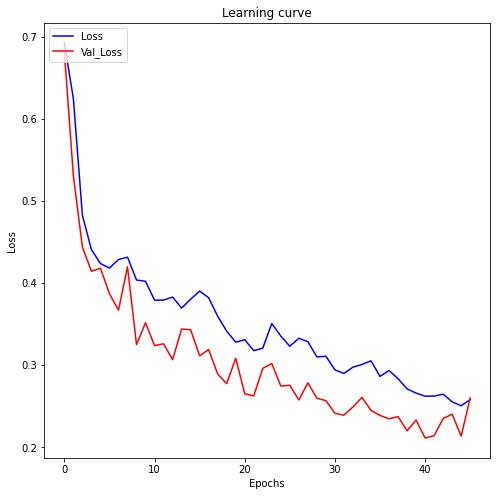

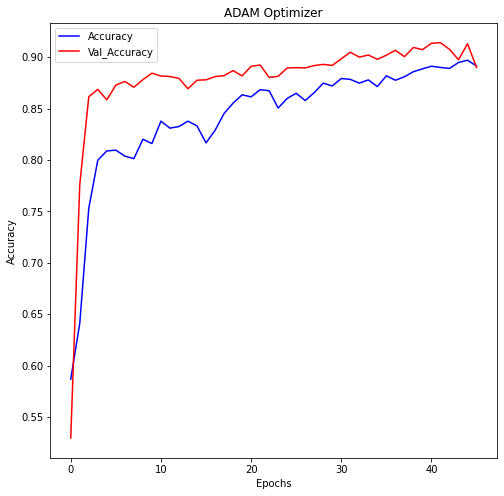

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history['loss'], color='b')
plt.plot(results.history['val_loss'], color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss', 'Val_Loss'], loc='upper left')
plt.show()



plt.figure(figsize=(8, 8))
plt.title("ADAM Optimizer")
plt.plot(results.history['accuracy'], color='b')
plt.plot(results.history['val_accuracy'], color='r')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy', 'Val_Accuracy'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_train, verbose=1)

7/7 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

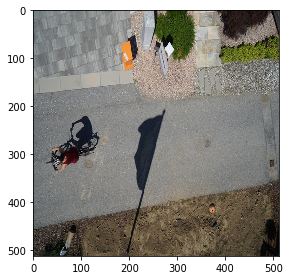

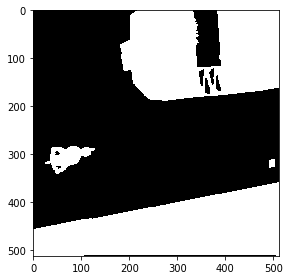

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


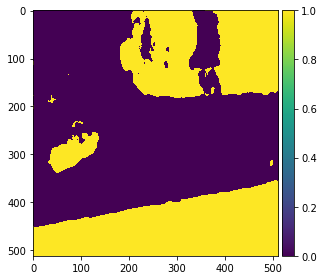

Done!


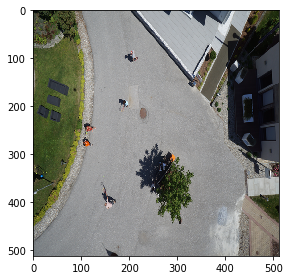

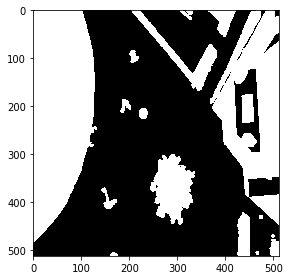

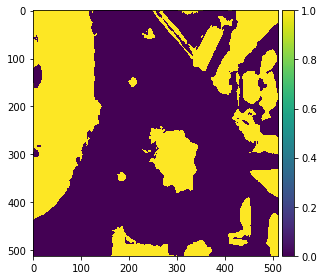

In [25]:

# train data
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()
print('Done!')

# validation data
ix = 2
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

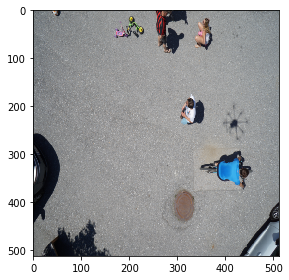

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


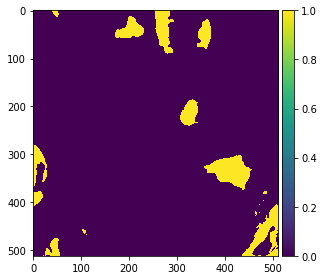

Done!


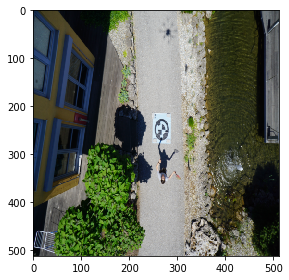

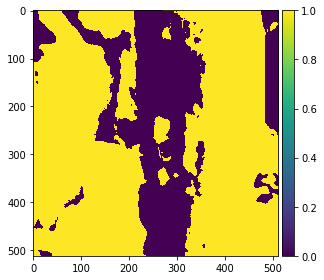

Done!


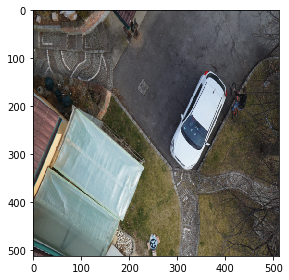

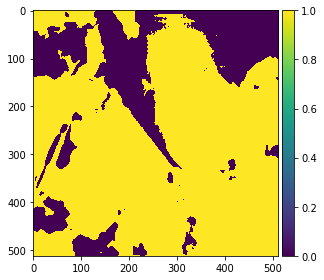

Done!


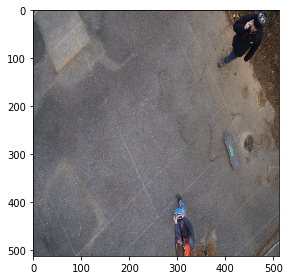

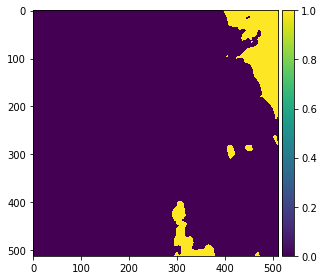

Done!


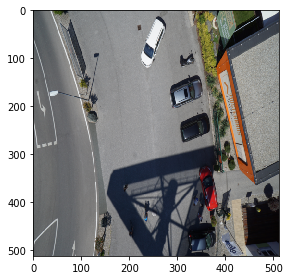

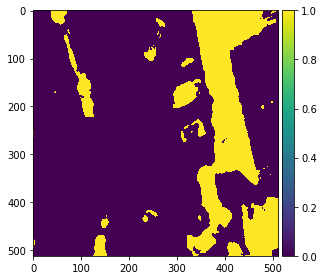

Done!


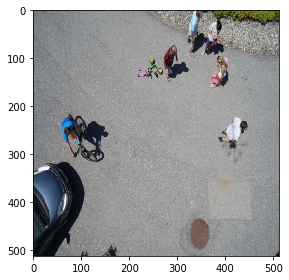

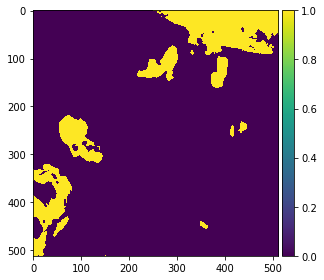

Done!


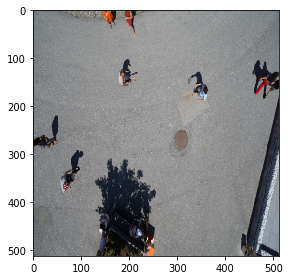

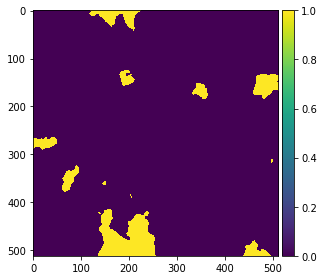

Done!


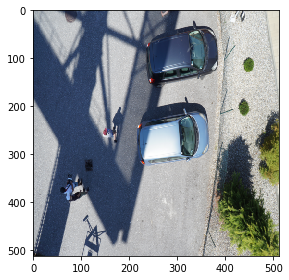

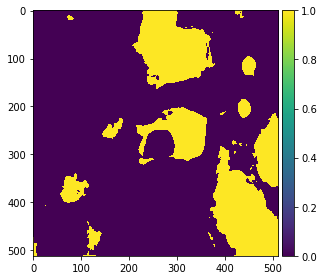

Done!


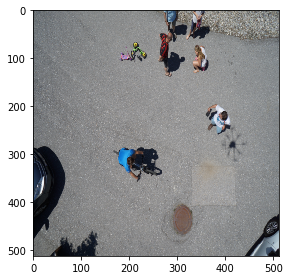

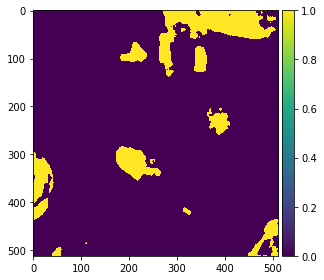

Done!


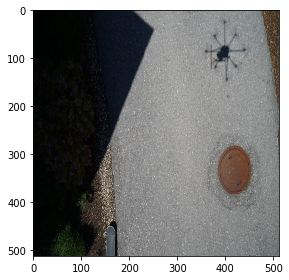

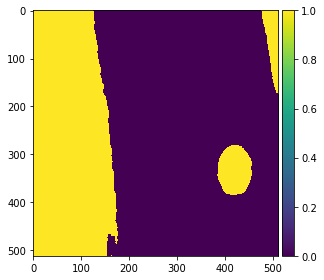

Done!


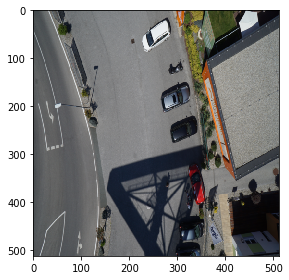

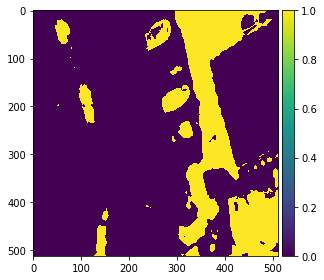

Done!


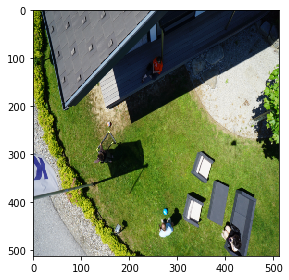

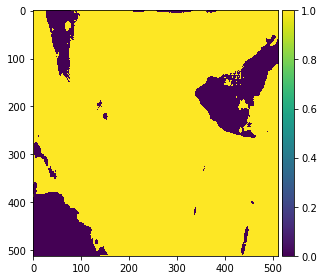

Done!


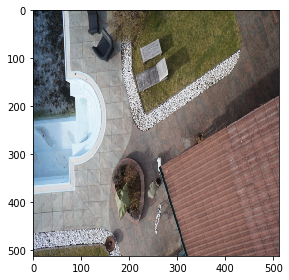

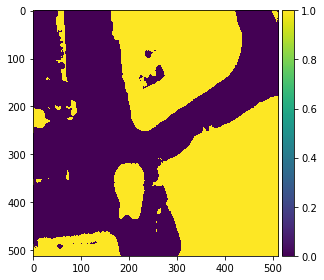

Done!


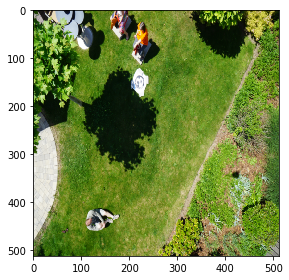

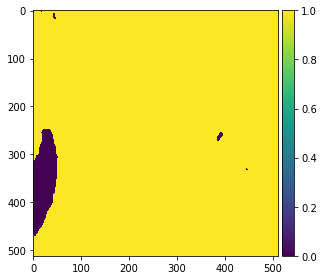

Done!


In [28]:

for ix in range(14):

 imshow(X_test[ix])                    
 plt.show()
 imshow(np.squeeze(preds_test_t[ix]))
 plt.show()
 print('Done!')